In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 60)
from scipy import stats
from tqdm import tqdm, trange
from random import seed

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier, LGBMRegressor
import xgboost
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/PrudentialData/train.csv")
test = pd.read_csv("/content/drive/MyDrive/PrudentialData/test.csv")


prudential_files= open('/content/drive/MyDrive/PrudentialData/prudential_files', 'rb')
train_final,cv_final, test_final= pickle.load(prudential_files)

file_medianImp_and_FE= open('/content/drive/MyDrive/PrudentialData/file_medianImp_and_FE', 'rb')
train_md, cv_md, test_md= pickle.load(file_medianImp_and_FE)

#imputation + FE
file_medianImp_and_FE = open('/content/drive/MyDrive/PrudentialData/file_medianImp_and_FE', 'rb')
train_md_FE, cv_md_FE, test_md_FE = pickle.load(file_medianImp_and_FE)

#Dataset_1

file_baseline= open('/content/drive/MyDrive/PrudentialData/files_baseline', 'rb')
train_xi,cv_xi, test_xi, train_yi, cv_yi= pickle.load(file_baseline)

# Dataset_2
 
file_median_impute = open('/content/drive/MyDrive/PrudentialData/file_median_impute', 'rb')
x_train_md_le, x_cv_md_le, x_test_md_le, y_train_md_le,y_cv_md_le, x_train_md_ohe, x_cv_md_ohe, x_test_md_ohe, y_train_md_ohe,y_cv_md_ohe= pickle.load(file_median_impute)

# Dataset_3
 
file_median_impute_withOut = open('/content/drive/MyDrive/PrudentialData/file_median_impute_withOut', 'rb')
x_train_out_md_le, x_cv_out_md_le, x_test_out_md_le, y_train_out_md_le, y_cv_out_md_le, x_train_out_md_ohe, x_cv_out_md_ohe, x_test_out_md_ohe, y_train_out_md_ohe,y_cv_out_md_ohe= pickle.load(file_median_impute_withOut)


#Dataset_4
file_median_impute_withoutSMOTE = open('/content/drive/MyDrive/PrudentialData/file_median_impute_withoutSMOTE', 'rb')
X_train_md_ohe,X_cv_md_ohe, X_test_md_ohe, Y_train_md_ohe, Y_cv_md_ohe = pickle.load(file_median_impute_withoutSMOTE)

RawDataFE = open('/content/drive/MyDrive/PrudentialData/RawDataFE', 'rb')
train_data_FE, cv_data_FE, test_data_FE = pickle.load(RawDataFE)



In [ ]:
print(train_final.shape, cv_final.shape, test_final.shape)
# print(train_md.shape, cv_md.shape, test_md.shape)
print(train_md_FE.shape, cv_md_FE.shape, test_md_FE.shape)
print(x_train_md_le.shape, x_cv_md_le.shape, x_test_md_le.shape)
print(x_train_md_ohe.shape, x_cv_md_ohe.shape, x_test_md_ohe.shape)

(47504, 119) (11877, 119) (19765, 118)
(47504, 78) (11877, 78) (19765, 77)
(124728, 76) (31184, 76) (19765, 76)
(124728, 120) (31184, 120) (19765, 120)


# Model Fitting

## Baseline Model

In [ ]:
#Random Predictions
seed(0)

def random_algorithm(train, cv):
	output_values = range(1,9)
	unique = list(output_values)
	predicted = list()
	for _ in range(cv.shape[0]):
		index = randrange(len(unique))
		predicted.append(unique[index])
	return predicted
cv_pred = random_algorithm(train_xi, cv_xi)

print("Kappa score on Cross Validation dataset: ", cohen_kappa_score(cv_yi, cv_pred))

Kappa score on Cross Validation dataset:  0.0056391846811076896


In [ ]:
## general function for model training and evaluation

def model(model_name, x_train, y_train, params, x_cv=None, y_cv=None):
  if params:
    clf = RandomizedSearchCV(model_name, params, random_state= 42, verbose=1, n_jobs=-1)
    clf.fit(x_train, y_train)
    return clf
  else:
    clf = model_name.fit(x_train, y_train)
    train_pred = clf.predict(x_train)
    cv_pred = clf.predict(x_cv)
    return clf, train_pred, cv_pred

##KNN

In [ ]:
# median imputation with Label Encoding
# param = {'n_neighbors':[3, 15, 25, 51, 101]}

knn_1, train_pred, cv_pred = model(KNeighborsClassifier(n_neighbors=5, n_jobs=-1), x_train_md_le, y_train_md_le, None, x_cv_md_le, y_cv_md_le)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_le, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_le, cv_pred))

Kappa Score for prediction with Training set:  0.8172846972154265
Kappa Score for prediction with Cross Validation set:  0.08451220406069049


In [ ]:
# median imputation with outliers removed and with Label Encoding

knn_2, train_pred, cv_pred = model(KNeighborsClassifier(), x_train_out_md_le, y_train_out_md_le, None, x_cv_out_md_le, y_cv_out_md_le)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_out_md_le, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_out_md_le, cv_pred))

Kappa Score for prediction with Training set:  0.8170189761492436
Kappa Score for prediction with Cross Validation set:  0.09393095360258008


## Naive Bayes

In [ ]:
nb_1, train_pred, cv_pred = model(GaussianNB(), x_train_md_le, y_train_md_le, params=None, x_cv=x_cv_md_le, y_cv= y_cv_md_le)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_le, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_le, cv_pred))

Kappa Score for prediction with Training set:  0.2668572528106875
Kappa Score for prediction with Cross Validation set:  0.2621124386132082


In [ ]:
## OUTLIERS Removed 
nb, train_pred, cv_pred = model(GaussianNB(), x_train_out_md_le, y_train_out_md_le, params=None, x_cv=x_cv_out_md_le, y_cv= y_cv_out_md_le)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_out_md_le, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_out_md_le, cv_pred))

Kappa Score for prediction with Training set:  0.22358137020442193
Kappa Score for prediction with Cross Validation set:  0.2287986513230228


## Logistic Regression

In [ ]:
lr_1, train_pred, cv_pred = model(LogisticRegression(multi_class='ovr',penalty='elasticnet',solver= 'saga',l1_ratio=0.5,n_jobs=-1), x_train_md_ohe, y_train_md_ohe, params=None, x_cv=x_cv_md_ohe, y_cv= y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.3434490594390537
Kappa Score for prediction with Cross Validation set:  0.3295829363043319


In [ ]:
### OUTLIERS removed
lr, train_pred, cv_pred = model(LogisticRegression(multi_class='ovr',penalty='l2'), x_train_out_md_ohe, y_train_out_md_ohe, params=None, x_cv=x_cv_out_md_ohe, y_cv= y_cv_out_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_out_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_out_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.3312717043715697
Kappa Score for prediction with Cross Validation set:  0.33405409367441175


## Linear Model

In [ ]:
#With hinge loss
sgd_hinge = SGDClassifier(loss='hinge',n_jobs=-1, random_state=1234)
sgd_hinge.fit(x_train_md_le, y_train_md_le)
train_pred = sgd_hinge.predict(x_train_md_le)
cv_pred = sgd_hinge.predict(x_cv_md_le)

print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_le, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_le, cv_pred))

Kappa Score for prediction with Training set:  0.19982224176951902
Kappa Score for prediction with Cross Validation set:  0.20303452319870996


In [ ]:
#With hinge loss
## OUTLIERS Removed

sgd = SGDClassifier()
sgd.fit(x_train_out_md_le, y_train_out_md_le)
train_pred = sgd.predict(x_train_out_md_le)
cv_pred = sgd.predict(x_cv_out_md_le)

print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_out_md_le, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_out_md_le, cv_pred))

Kappa Score for prediction with Training set:  0.18978898082226925
Kappa Score for prediction with Cross Validation set:  0.19152679029538955


In [ ]:
#With Log loss
sgd_log = SGDClassifier(loss='log', penalty='l2', random_state=42)
sgd_log.fit(x_train_md_le, y_train_md_le)
train_pred = sgd_log.predict(x_train_md_le)
cv_pred = sgd_log.predict(x_cv_md_le)

print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_le, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_le, cv_pred))

Kappa Score for prediction with Training set:  0.11532294272336607
Kappa Score for prediction with Cross Validation set:  0.11797258667448507


In [ ]:
#With Log loss
## OUTLIERS Removed

sgd = SGDClassifier(loss='log', penalty='l2', random_state=42)
sgd.fit(x_train_out_md_le, y_train_out_md_le)
train_pred = sgd.predict(x_train_out_md_le)
cv_pred = sgd.predict(x_cv_out_md_le)

print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_out_md_le, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_out_md_le, cv_pred))

Kappa Score for prediction with Training set:  0.2591788302775411
Kappa Score for prediction with Cross Validation set:  0.2629920105548633


## Decision Tree

In [ ]:
params = {'max_depth': [3,5,7,9,11,13,15], 'min_samples_split':[0.1,0.3,0.5,0.7]}
dt_1= model(DecisionTreeClassifier(), x_train_md_ohe, y_train_md_ohe, params=params, x_cv=x_cv_md_ohe, y_cv= y_cv_md_ohe)
dt_1.best_params_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.3s finished


{'max_depth': 9, 'min_samples_split': 0.1}

In [ ]:
dt_1, train_pred, cv_pred = model(DecisionTreeClassifier(max_depth=9, min_samples_split=0.1, random_state=1234), x_train= x_train_md_ohe,y_train= y_train_md_ohe, params=None,x_cv= x_cv_md_ohe,y_cv= y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.3281288655543033
Kappa Score for prediction with Cross Validation set:  0.32364582569816025


Test Score: 0.43823

In [ ]:
#hyperparameter Tuning Decision tree
param = {'max_depth': [2, 3, 5, 10, 20], 'min_samples_leaf': [5, 10, 20, 50, 100], 'criterion': ["gini", "entropy"]}
dt = model(DecisionTreeClassifier(), x_train_md_ohe, y_train_md_ohe, param, x_cv_md_ohe, y_cv_md_ohe)
dt.best_estimator_


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
dt = DecisionTreeClassifier(max_depth =7, min_samples_leaf= 100, criterion='gini')
dt.fit(x_train_md_ohe, y_train_md_ohe)
train_pred= dt.predict(x_train_md_ohe)
cv_pred= dt.predict(x_cv_md_ohe)

print("Kappa Score for predi  ction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for predi  ction with Training set:  0.3987740179774045
Kappa Score for prediction with Cross Validation set:  0.3902734002785311


In [ ]:
### Only Median imputation , WITHOUT SMOTE

dt = DecisionTreeClassifier(max_depth =10, min_samples_leaf= 100, criterion='gini')
dt.fit(X_train_md_ohe, Y_train_md_ohe)
train_pred= dt.predict(X_train_md_ohe)
cv_pred= dt.predict(X_cv_md_ohe)

print("Kappa Score for prediction with Training set: ", cohen_kappa_score(Y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(Y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.3842604255389598
Kappa Score for prediction with Cross Validation set:  0.3600283887862755


### Testing the misclassification

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
     
    plt.figure(figsize=(20,10))
    
    labels = np.arange(1,9)
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()

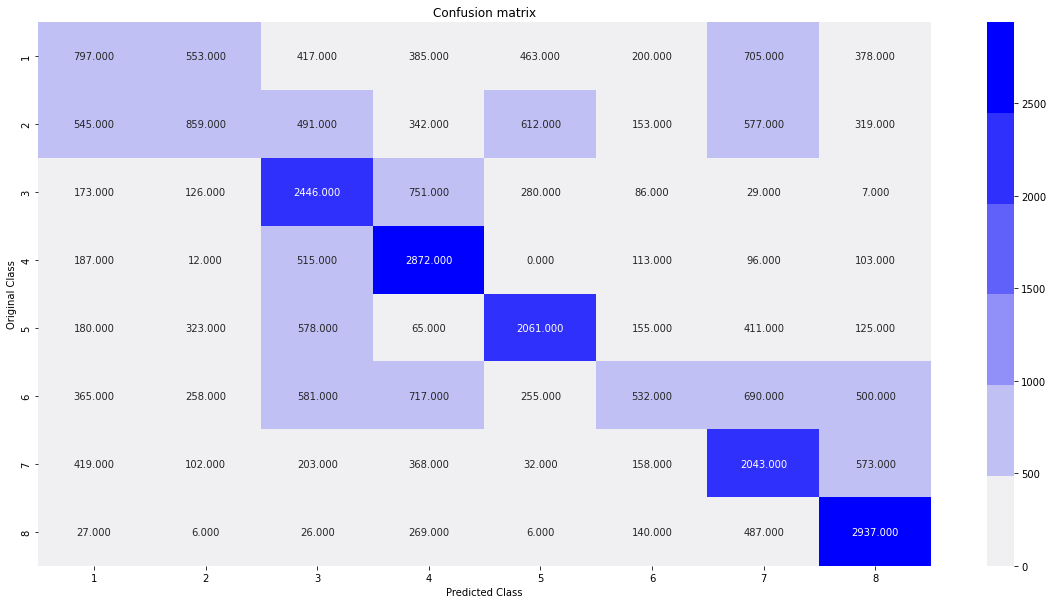

In [ ]:
plot_confusion_matrix(y_cv_md_le, cv_pred)

# Ensemble Techniques

## Random Forest

In [ ]:
%%time
params= {'max_depth': [5,10, 15,20,None],
 'min_samples_leaf': [1, 2, 4],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400]}

rf_1= model(RandomForestClassifier(n_jobs=-1), x_train_md_ohe, y_train_md_ohe, params=params,
                                 x_cv=x_cv_md_ohe, y_cv=y_cv_md_ohe)
rf_1.best_params_

{'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 800}

using the above best paramters the model was highy overfitting, train score was 0.90 whereas cross validation was 0.46

In [ ]:
rf= RandomForestClassifier(max_depth=10, n_estimators=50,min_samples_leaf=2)
rf.fit(x_train_md_ohe, y_train_md_ohe)
rf_train_pred= rf.predict(x_train_md_ohe)
rf_cv_pred= rf.predict(x_cv_md_ohe)

print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, rf_train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, rf_cv_pred))

Kappa Score for prediction with Training set:  0.49990379064845103
Kappa Score for prediction with Cross Validation set:  0.4230374551051821


In [ ]:
pd.DataFrame(rf.predict(x_test_md_ohe),index=test_final['Id'], columns=['Response']).to_csv("/content/x_test_mf_ohe_rf_prediction.csv")

In [ ]:
### OUTLIERs Removed

rf= RandomForestClassifier(max_depth=10, n_estimators=500, min_samples_split=2)
rf.fit(x_train_out_md_ohe, y_train_out_md_ohe)
train_pred= rf.predict(x_train_out_md_ohe)
cv_pred= rf.predict(x_cv_out_md_ohe)

print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_out_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_out_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.4344722687997654
Kappa Score for prediction with Cross Validation set:  0.3379022209191527


Test Score : 0.45635


In [ ]:
### Only Median imputation , WITHOUT SMOTE

rf= RandomForestClassifier(max_depth=5, n_estimators=250, min_samples_split=2, class_weight='balanced')
rf.fit(X_train_md_ohe, Y_train_md_ohe)
train_pred= rf.predict(X_train_md_ohe)
cv_pred= rf.predict(X_cv_md_ohe)

print("Kappa Score for prediction with Training set: ", cohen_kappa_score(Y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(Y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.2785100583842328
Kappa Score for prediction with Cross Validation set:  0.2716651803298066


### Testing the misclassification 
Dataset = cv_md

Using Random Forest Predictions {max_depth=10, n_estimators=50,min_samples_leaf=2}


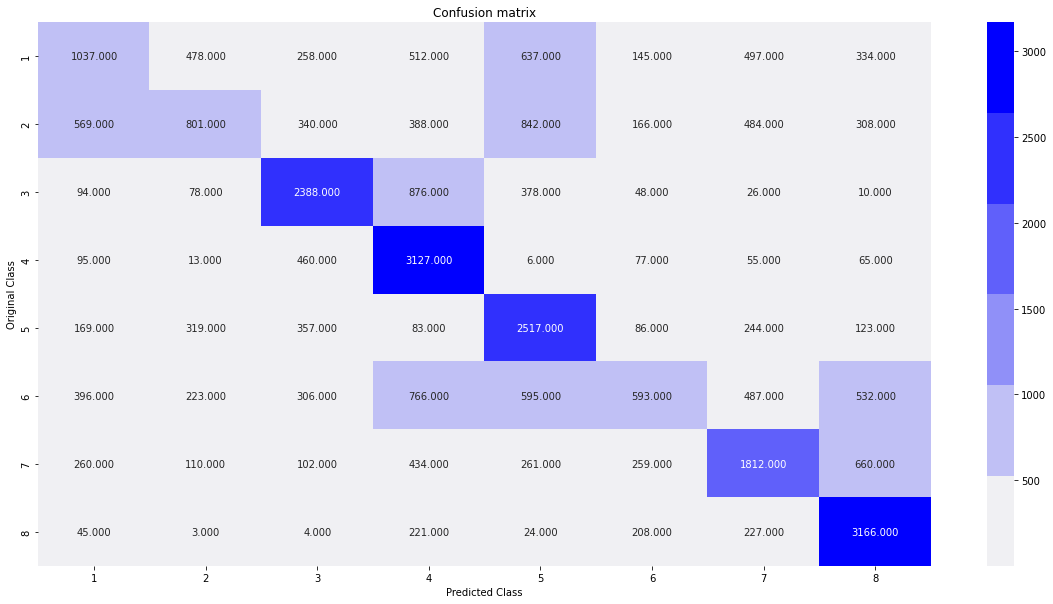

In [ ]:
print("Using Random Forest Predictions {max_depth=10, n_estimators=50,min_samples_leaf=2}")
plot_confusion_matrix(y_cv_md_le, rf_cv_pred)


## ExtraTrees Classifier

In [ ]:
params = {'max_depth':[5, 10,15,20,50,None],
          'min_samples_split':[2,4],
          'min_samples_leaf': [1,2,4]}
et= model(ExtraTreeClassifier(), x_train_md_ohe, y_train_md_ohe, params=params, x_cv=x_cv_md_ohe, y_cv= y_cv_md_ohe)
et.best_params_
# print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
# print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.6s finished


{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [ ]:
et=None
et, train_pre, cv_pred= model(ExtraTreeClassifier(max_depth =None ,min_samples_leaf= 1, min_samples_split= 2,random_state=1234), x_train_md_ohe, y_train_md_ohe, params=None, 
                              x_cv=x_cv_md_ohe, y_cv= y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.3987740179774045
Kappa Score for prediction with Cross Validation set:  0.2050868577292384


In [ ]:
## WITHOUT SMOTE
et, train_pred, cv_pred = model(ExtraTreeClassifier(max_depth=10), X_train_md_ohe, Y_train_md_ohe, params=None, x_cv=X_cv_md_ohe, y_cv= Y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(Y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(Y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.28695723479295776
Kappa Score for prediction with Cross Validation set:  0.25490067916348713


## XG Boost

In [ ]:
##XGBOOST with booster as linear, mas_depth=11, learning rate=0.05, n_estimators= 1000
%%time
# params= {'max_depth':[3,5,8,10], 'learning_rate':[0.01, 0.05,0.1,0.2], 'n_estimators':[100,200,500,1000]}
xgb, train_pred, cv_pred = model(XGBClassifier(booster='gblinear',max_depth= 11, learning_rate =0.05,
                                               min_child_weight=50, subsample=0.5, colsample_bytree=0.3, silent=1, n_jobs=-1,
                                               random_state=42, n_estimators=1000), x_train_md_ohe, y_train_md_ohe, params=None,x_cv=x_cv_md_ohe, y_cv= y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.17670450901160928
Kappa Score for prediction with Cross Validation set:  0.17749028805981093
CPU times: user 41min 49s, sys: 1.85 s, total: 41min 51s
Wall time: 21min 15s


In [ ]:
#XGBOOST with max_depth=3, learning_rate =0.1, n_estimators=500
%%time
# params= {'max_depth':[3,5,8,10], 'learning_rate':[0.01, 0.05,0.1,0.2], 'n_estimators':[100,200,500,1000]}
xgb, train_pred, cv_pred = model(XGBClassifier(max_depth= 3, learning_rate =0.01,n_jobs=-1, random_state=42, n_estimators=1000, min_child_weight=2), x_train_md_ohe, y_train_md_ohe, params=None,x_cv=x_cv_md_ohe, y_cv= y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.47873773330767755
Kappa Score for prediction with Cross Validation set:  0.4567177307043905
CPU times: user 1h 33min 1s, sys: 10.6 s, total: 1h 33min 12s
Wall time: 48min 10s


In [ ]:
#XGBOOST with max_depth=3, learning_rate =0.1, n_estimators=500
%%time
# params= {'max_depth':[3,5,8,10], 'learning_rate':[0.01, 0.05,0.1,0.2], 'n_estimators':[100,200,500,1000]}
xgb, train_pred, cv_pred = model(XGBClassifier(max_depth= 3, learning_rate =0.01,n_jobs=-1, random_state=42, n_estimators=1500, min_child_weight=2), x_train_md_ohe, y_train_md_ohe, params=None,x_cv=x_cv_md_ohe, y_cv= y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

In [ ]:
xgb, train_pred, cv_pred = model(XGBClassifier(max_depth= 11, learning_rate =0.2,
                                               min_child_weight=50, subsample=0.5, colsample_bytree=0.3, silent=1, n_jobs=-1,
                                               random_state=42, n_estimators=500), x_train_md_ohe, y_train_md_ohe, params=None,x_cv=x_cv_md_ohe, y_cv= y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.9160596314723696
Kappa Score for prediction with Cross Validation set:  0.45873341640401666


In [ ]:
pd.DataFrame(xgb.predict(x_test_md_ohe),index=test_final['Id'], columns=['Response']).to_csv("/content/xgboost_predictions.csv")

### train and test data with outliers removed

In [ ]:
# params= {'max_depth':[3,5,10,15], 'learning_rate':[0.01, 0.05,0.1,0.2], 'n_estimators':[100,200,500,1000]}
xgb, train_pred, cv_pred= model(XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=200), x_train_out_md_ohe, y_train_out_md_ohe, params=None,
                                 x_cv=x_cv_out_md_ohe, y_cv=y_cv_out_md_ohe)

print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_out_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(x_cv_out_md_ohe, cv_pred))

In [ ]:
xgb, train_pred, cv_pred = model(XGBClassifier(learning_rate=0.03, n_estimators=400, max_depth =6, subsample=0.9, min_child_weight=240,objective= "reg:linear",n_jobs=-1, random_state=42), x_train_md_ohe, y_train_md_ohe, params=None,x_cv=x_cv_md_ohe, y_cv= y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.6321504164490503
Kappa Score for prediction with Cross Validation set:  0.48841896943487506



## LightGBM

In [ ]:
#Median imputation with one hot encoding
params= {'learning_rate':[0.001,0.05, 0.01,0.1,0.2], 'n_estimators':[50,100,200,500]}
lgbm=model(LGBMClassifier(random_state=1234), x_train_md_ohe, y_train_md_ohe, params, x_cv_md_ohe, y_cv_md_ohe)
lgbm.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 101.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 103.7min finished


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgbm = LGBMClassifier(learning_rate=0.3, n_estimators=200,max_depth=2, random_state= 1234)
lgbm.fit(x_train_md_ohe, y_train_md_ohe)
train_pred = lgbm.predict(x_train_md_ohe)
cv_pred = lgbm.predict(x_cv_md_ohe)

print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.5278045025976525
Kappa Score for prediction with Cross Validation set:  0.4868430697060764


In [ ]:
pd.DataFrame(lgbm.predict(x_test_md_ohe),index=test_final['Id'], columns=['Response']).to_csv("/content/lgbm_predictions_md_ohe.csv")

Test score 0.53068




In [ ]:
lgbm, train_pred, cv_pred = model(LGBMClassifier(max_depth=3, n_estimators=75, learning_rate=0.3, random_state=1234, n_jobs=-1), x_train_md_ohe, y_train_md_ohe,None, x_cv_md_ohe, y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.5258986411574443
Kappa Score for prediction with Cross Validation set:  0.4768745877006524


In [ ]:
## Median Imputation without SMOTE
lgbm, train_pred, cv_pred = model(LGBMClassifier(max_depth=3, n_estimators=250, learning_rate=0.3, random_state=1234, n_jobs=-1), X_train_md_ohe, Y_train_md_ohe,None, X_cv_md_ohe, Y_cv_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(Y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(Y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.4843364244193311
Kappa Score for prediction with Cross Validation set:  0.4036882123037532


### Testing for misclassification

Using LGBM Predictions {learning_rate=0.3, n_estimators=200,max_depth=2}


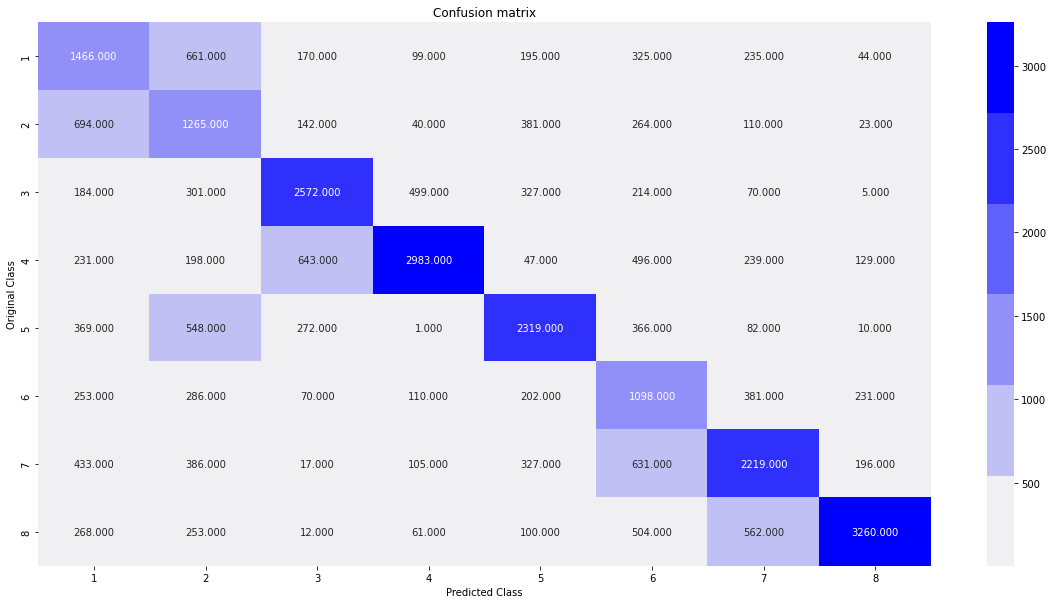

In [ ]:
print("Using LGBM Predictions {learning_rate=0.3, n_estimators=200,max_depth=2}")
plot_confusion_matrix(cv_pred, y_cv_md_ohe)

## ADA Boost Classifier

In [ ]:
ada, train_pred, cv_pred = model(AdaBoostClassifier(n_estimators=50), x_train_md_le, y_train_md_le, params=None,x_cv= x_cv_md_le, y_cv=y_train_md_le)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

Kappa Score for prediction with Training set:  0.3937528061060869
Kappa Score for prediction with Cross Validation set:  0.3942681228468812


## CatBoost Classifier

https://www.analyticsvidhya.com/blog/2017/08/catboost-automated-categorical-data/

In [ ]:
params={'learning_rate':[0.1,0.3,0.5,0.7], 
        'depth':[None,1, 3,5,7],
        'iterations':[50,75,100,200,250, 500]}
cat= model(CatBoostClassifier(), x_train_md_ohe, y_train_md_ohe, params=params,x_cv= x_cv_md_ohe, y_cv=y_train_md_ohe)
cat.best_params_


{'depth': 7, 'iterations': 100, 'learning_rate': 0.7}

In [ ]:
cat, train_pred, cv_pred= model(CatBoostClassifier(depth=3, iterations=50, learning_rate=0.5), x_train_md_ohe, y_train_md_ohe, params=None, x_cv= x_cv_md_ohe, y_cv=y_train_md_ohe)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))

0:	learn: 1.8055274	total: 460ms	remaining: 22.6s
1:	learn: 1.6795271	total: 851ms	remaining: 20.4s
2:	learn: 1.6284931	total: 1.23s	remaining: 19.3s
3:	learn: 1.5858614	total: 1.58s	remaining: 18.2s
4:	learn: 1.5583252	total: 1.9s	remaining: 17.1s
5:	learn: 1.5340035	total: 2.31s	remaining: 17s
6:	learn: 1.5119630	total: 2.73s	remaining: 16.8s
7:	learn: 1.4921261	total: 3.03s	remaining: 15.9s
8:	learn: 1.4736045	total: 3.44s	remaining: 15.7s
9:	learn: 1.4578553	total: 3.79s	remaining: 15.1s
10:	learn: 1.4458572	total: 4.12s	remaining: 14.6s
11:	learn: 1.4317461	total: 4.45s	remaining: 14.1s
12:	learn: 1.4199141	total: 4.79s	remaining: 13.6s
13:	learn: 1.4084388	total: 5.14s	remaining: 13.2s
14:	learn: 1.3955542	total: 5.43s	remaining: 12.7s
15:	learn: 1.3898175	total: 5.74s	remaining: 12.2s
16:	learn: 1.3818729	total: 6.13s	remaining: 11.9s
17:	learn: 1.3724156	total: 6.48s	remaining: 11.5s
18:	learn: 1.3636441	total: 6.87s	remaining: 11.2s
19:	learn: 1.3534002	total: 7.22s	remaining:

In [ ]:
pd.DataFrame(cat.predict(x_test_md_ohe),index= test_final['Id'], columns=['Response']).to_csv('/content/test_catboostpredictions.csv')

In [ ]:
## Removing Floating varibale columns and trying CAT BOOST CLASSIFIER

float_features = train_final.columns[train_final.dtypes =='float64']
train_catboost = train_final.copy()
cv_catboost = cv_final.copy()
test_catboost = test_final.copy()
print("Shapes before dropping Floating features TRAINING :{0}, CV :{1}, TEST :{2}:".format(train_catboost.shape,cv_catboost.shape, test_catboost.shape))

train_catboost = train_catboost.drop(float_features, axis=1)
cv_catboost = cv_catboost.drop(float_features, axis=1)
test_catboost = test_catboost.drop(float_features, axis=1)
print("Shapes after dropping Floating features TRAINING :{0}, CV :{1}, TEST :{2}:".format(train_catboost.shape,cv_catboost.shape, test_catboost.shape))

Shapes before dropping Floating features TRAINING :(47504, 119), CV :(11877, 119), TEST :(19765, 118):
Shapes after dropping Floating features TRAINING :(47504, 110), CV :(11877, 110), TEST :(19765, 109):


In [ ]:
x_train_catboost = train_catboost.drop(['Id','Response'],axis=1)
y_train_catboost = train_catboost['Response']
x_cv_catboost = cv_catboost.drop(['Id','Response'],axis=1)
y_cv_catboost = cv_catboost['Response']
x_test_catboost = test_catboost.drop(['Id'],axis=1)

encode = LabelEncoder()
x_train_catboost['Product_Info_2'] = encode.fit_transform(x_train_catboost['Product_Info_2'])
x_cv_catboost['Product_Info_2'] = encode.transform(x_cv_catboost['Product_Info_2'])
x_test_catboost['Product_Info_2'] = encode.transform(x_test_catboost['Product_Info_2'])


In [ ]:
##results with only Categorical features
cat, train_pred, cv_pred = model(CatBoostClassifier(depth =3, learning_rate=0.3, iterations=500, random_state=42), x_train=x_train_catboost, y_train= y_train_catboost, params=None, x_cv = x_cv_catboost, y_cv = y_cv_catboost)
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_catboost, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_catboost, cv_pred))

0:	learn: 1.8227802	total: 89.2ms	remaining: 44.5s
1:	learn: 1.7422748	total: 177ms	remaining: 44.1s
2:	learn: 1.6966151	total: 267ms	remaining: 44.3s
3:	learn: 1.6654051	total: 345ms	remaining: 42.8s
4:	learn: 1.6451612	total: 415ms	remaining: 41.1s
5:	learn: 1.6301980	total: 491ms	remaining: 40.4s
6:	learn: 1.6193855	total: 580ms	remaining: 40.8s
7:	learn: 1.6102908	total: 652ms	remaining: 40.1s
8:	learn: 1.6035963	total: 737ms	remaining: 40.2s
9:	learn: 1.5984834	total: 819ms	remaining: 40.1s
10:	learn: 1.5879504	total: 903ms	remaining: 40.2s
11:	learn: 1.5835395	total: 980ms	remaining: 39.9s
12:	learn: 1.5802376	total: 1.07s	remaining: 40s
13:	learn: 1.5759407	total: 1.14s	remaining: 39.7s
14:	learn: 1.5728461	total: 1.22s	remaining: 39.4s
15:	learn: 1.5608608	total: 1.31s	remaining: 39.6s
16:	learn: 1.5545686	total: 1.38s	remaining: 39.1s
17:	learn: 1.5526969	total: 1.45s	remaining: 38.8s
18:	learn: 1.5507531	total: 1.53s	remaining: 38.7s
19:	learn: 1.5492527	total: 1.59s	remainin

## Voting Classifier


In [ ]:
# group / ensemble of models
estimator = []
estimator.append(('CATBOOST', 
                  CatBoostClassifier(max_depth=3, iterations=50, learning_rate=0.5)))
estimator.append(('ADA', AdaBoostClassifier(n_estimators=50)))
estimator.append(('LGBM', LGBMClassifier(max_depth=3, n_estimators=75, learning_rate=0.3, n_jobs=-1)))
  
# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='soft')
vot_hard.fit(x_train_md_ohe, y_train_md_ohe)
train_pred =np.argmax(vot_hard.predict_proba(x_train_md_ohe),axis=1)+1
cv_pred =np.argmax(vot_hard.predict_proba(x_cv_md_ohe),axis=1)+1
print("Kappa Score for prediction with Training set: ", cohen_kappa_score(y_train_md_ohe, train_pred))
print("Kappa Score for prediction with Cross Validation set: ", cohen_kappa_score(y_cv_md_ohe, cv_pred))


0:	learn: 1.8055274	total: 535ms	remaining: 26.2s
1:	learn: 1.6795271	total: 941ms	remaining: 22.6s
2:	learn: 1.6284931	total: 1.34s	remaining: 21s
3:	learn: 1.5858614	total: 1.72s	remaining: 19.8s
4:	learn: 1.5583252	total: 2.08s	remaining: 18.7s
5:	learn: 1.5340035	total: 2.5s	remaining: 18.3s
6:	learn: 1.5119630	total: 2.95s	remaining: 18.1s
7:	learn: 1.4921261	total: 3.27s	remaining: 17.1s
8:	learn: 1.4736045	total: 3.72s	remaining: 17s
9:	learn: 1.4578553	total: 4.09s	remaining: 16.4s
10:	learn: 1.4458572	total: 4.45s	remaining: 15.8s
11:	learn: 1.4317461	total: 4.79s	remaining: 15.2s
12:	learn: 1.4199141	total: 5.16s	remaining: 14.7s
13:	learn: 1.4084388	total: 5.52s	remaining: 14.2s
14:	learn: 1.3955542	total: 5.83s	remaining: 13.6s
15:	learn: 1.3898175	total: 6.17s	remaining: 13.1s
16:	learn: 1.3818729	total: 6.58s	remaining: 12.8s
17:	learn: 1.3724156	total: 6.97s	remaining: 12.4s
18:	learn: 1.3636441	total: 7.38s	remaining: 12s
19:	learn: 1.3534002	total: 7.77s	remaining: 11.

In [ ]:
pd.DataFrame(np.argmax(vot_hard.predict_proba(x_test_md_ohe),axis=1),index= test_final['Id'], columns=['Response']).to_csv("/content/voting_classifier.csv")

In [ ]:
import joblib
#dumping trained models

filename = '/content/drive/MyDrive/PrudentialData/finalized_model_rf.sav'
joblib.dump(rf_1, filename)
 
# some time later...
 
# load the model from disk
rf_1= joblib.load(filename)

# CUSTOM Model (k base models and later stacking their predictions)


In [ ]:
## Loading Raw dataset with feature engineering done and label encoding also.
train = train_data_FE.copy()
cv = cv_data_FE.copy()
test = test_data_FE.copy()
test = test.drop('Id',axis=1)

train = pd.concat((train, cv))
print(train.shape)
train.head()

(59381, 87)


,Id,Product_Info_1,Product_Info_2,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Wt,BMI,Employment_Info_1,Employment_Info_4,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,...,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Response,Height_cat,BMI_cat,Ins_Age_cat,Wt_cat,Medical_Keyword,BMI_AGE,Wt_AGE,Ht_AGE,high_risk,Prod_Info_3_Emp_Info_5,Employment_Info2_3_cooccur,Ht/InsuredInfo_6,Product_Info_2_char,Product_Info_2_no
38963,51725,1,15,0.384615,2,3,1,0.552239,0.322176,0.446623,0.100,0.00,0.35,1,2,11,3,1,1,1,1,1,0.003000,1,1,2,3,0.608696,-1.000000,0.507042,-1.000000,1.0,171,2,1,1,3,2,2,1,...,3,1,1,2,2,2,3,-1.0,1,3,3,1,1,2,3,-1.0,3,3,1,2,2,1,3,3,3,8,2,2,0,0,2,0.246642,0.177918,0.431750,0.0,52,0.0,0.781818,3,2
38922,51668,1,17,1.000000,2,3,1,0.164179,0.539749,0.637699,0.060,-1.00,0.15,1,2,4,3,1,1,2,1,3,-1.000000,3,2,3,3,0.420290,-1.000000,0.338028,-1.000000,8.0,260,2,1,1,3,2,2,2,...,3,1,1,2,1,2,3,-1.0,1,3,3,1,3,2,3,-1.0,3,3,1,2,2,1,3,3,1,5,2,0,2,1,0,0.104697,0.088615,0.146269,0.0,52,0.0,0.890909,3,4
15466,20614,1,18,0.128205,2,3,1,0.462687,0.251046,0.496592,0.000,0.04,0.50,1,2,3,3,1,1,2,1,1,0.000419,1,3,1,3,-1.000000,0.617647,0.591549,-1.000000,1.0,613,3,2,1,3,2,2,2,...,3,1,2,2,1,2,3,-1.0,1,3,3,1,1,2,3,-1.0,3,3,1,2,2,1,3,3,3,2,1,2,0,0,5,0.229767,0.116156,0.286024,0.0,52,1.0,0.309091,4,1
38282,50821,1,9,0.230769,2,3,1,0.447761,0.225941,0.510720,0.025,0.00,0.00,1,2,6,3,1,3,2,1,2,0.000100,1,3,2,3,-1.000000,0.500000,0.478873,-1.000000,9.0,491,2,2,1,3,2,2,2,...,3,1,1,2,1,2,1,-1.0,1,3,3,1,3,2,3,-1.0,3,3,1,2,2,1,3,3,1,6,1,2,0,0,1,0.228680,0.101168,0.252374,0.0,52,0.0,0.281818,1,2
36843,48931,1,14,0.230769,2,3,1,0.507463,0.309623,0.565608,0.000,0.00,-1.00,1,2,8,3,1,1,2,1,3,-1.000000,3,2,3,3,-1.000000,0.529412,-1.000000,0.419643,1.0,276,2,1,1,3,2,2,2,...,3,1,1,2,1,2,3,-1.0,1,3,3,1,1,2,3,-1.0,1,3,1,2,2,1,3,3,1,6,0,0,0,0,4,0.287025,0.157122,0.332157,0.0,30,1.0,0.327273,3,1


### Splitting the training dataset into 50-50

In [ ]:
D1_50, D2_50, y1_50, y2_50 = train_test_split(train.drop(['Id','Response'],axis=1), train['Response'], test_size=0.5, stratify=train['Response'], random_state=42)
print("Shape of train data: ", D1_50.shape)
print("Shape of test data: ", D2_50.shape)

Shape of train data:  (29690, 85)
Shape of test data:  (29691, 85)


# 1

### Creating k Models(LightGBM)

In [ ]:
def get_kmodels(x, y, k, size):
    '''This function generates creates k random samples from data
       and then fits k different models on them'''
    models = []
    for i in range(k):
        indices = np.random.choice(len(x), size, replace=True)
        xi, yi = x.iloc[indices], y.iloc[indices]
        # model = LogisticRegression(C=0.23357214690901212, class_weight='balanced',
        #                            max_iter=1000).fit(xi, yi)
        model = LGBMClassifier(max_depth =3, learning_rate=0.3, n_jobs=-1 ).fit(xi, yi)
        models.append(model)
    return models

### Stacked Classifier on Meta data with k predictions

In [ ]:
def generate_data(x, models):
    '''This function generates metadata with k predictions of k models'''
    res_x = []
    for model_ in models:
        res_x.append(model_.predict(x))
    res_x = np.array(res_x).T
    
    return res_x

### LightGBM as Stack Classifier

In [ ]:
def quadratic_kappa_score(ground_truth, predictions):
    return cohen_kappa_score(ground_truth, predictions, weights='quadratic')

In [ ]:

# Hypertuning 'k' using lightgbm as as Stack Classifier
from tqdm import tqdm
scores = []
lightgbm_models = []

for k in tqdm([20, 50, 100, 150, 200]):
    #Generating models
    models = get_kmodels(D1_50, y1_50, k, 5000)
    # Generating meta-data
    x_meta = generate_data(D2_50, models)
    y_meta = y2_50

    clf = GridSearchCV(LGBMClassifier(class_weight='balanced'),
                       param_grid = {'learning_rate': [0.001, 0.002, 0.005, 0.1, 0.3, 0.5, 0.7],
                                     'n_estimators': [50, 100, 200, 300, 500]},
                       scoring=make_scorer(quadratic_kappa_score, greater_is_better=True), verbose=1,
                       n_jobs=-1, cv=3)

    clf.fit(x_meta, y_meta)
    scores.append(clf.best_score_)
    lightgbm_models.append(clf.best_estimator_)
    

print()
print("Results for lightgbm model")
print("k: ", [20, 50, 100, 200, 500])
print("F1 score: ", scores)
print()
print(lightgbm_models[np.argmax(scores)])

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 10.4min finished
 20%|██        | 1/5 [11:05<44:23, 665.96s/it]

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 18.8min finished
 40%|████      | 2/5 [31:44<50:08, 1002.70s/it]

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 32.0min finished
 60%|██████    | 3/5 [1:07:51<51:09, 1534.53s/it]

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 45.1min finished
 80%|████████  | 4/5 [1:59:42<35:56, 2156.91s/it]

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 58.8min finished
100%|██████████| 5/5 [3:07:24<00:00, 2248.98s/it]


Results for lightgbm model
k:  [20, 50, 100, 200, 500]
F1 score:  [0.5482780649814829, 0.5505648648899505, 0.5571184425587261, 0.5591000431228068, 0.556939874179319]

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.005, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


# 2

### Creating k Models(Xgboost)

In [ ]:
def get_kmodels(x, y, k, size):
    '''This function generates creates k random samples from data
       and then fits k different models on them'''
    models = []
    for i in range(k):
        indices = np.random.choice(len(x), size, replace=True)
        xi, yi = x.iloc[indices], y.iloc[indices]
        # model = LogisticRegression(C=0.23357214690901212, class_weight='balanced',
        #                            max_iter=1000).fit(xi, yi)
        model = XGBClassifier(max_depth =6, learning_rate=0.1,n_estimators=500, min_child_weight=60, subsample=0.9, colsample_bytree=0.6, n_jobs=-1).fit(xi, yi)
        models.append(model)
    return models

### Stacked Classifier on Meta data with k predictions

In [ ]:
def generate_data(x, models):
    '''This function generates metadata with k predictions of k models'''
    res_x = []
    for model_ in models:
        res_x.append(model_.predict(x))
    res_x = np.array(res_x).T
    
    return res_x

### Random Forest as Stack Classifier

In [ ]:
def quadratic_kappa_score(ground_truth, predictions):
    return cohen_kappa_score(ground_truth, predictions, weights='quadratic')

In [ ]:

# Hypertuning 'k' using lightgbm as as Stack Classifier
from tqdm import tqdm
scores = []
Xgboost_models = []

for k in tqdm([20, 50, 100, 150, 200]):
    #Generating models
    models = get_kmodels(D1_50, y1_50, k, 2000)
    # Generating meta-data
    x_meta = generate_data(D2_50, models)
    y_meta = y2_50

    clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                       param_grid = {'max_depth': [3, 5, 7, 10, 15, 20],
                                     'n_estimators': [50, 100, 200, 300, 500]},
                       scoring=make_scorer(quadratic_kappa_score, greater_is_better=True), verbose=1,
                       n_jobs=-1, cv=3)

    clf.fit(x_meta, y_meta)
    scores.append(clf.best_score_)
    Xgboost_models.append(clf.best_estimator_)
    

print()
print("Results for Xgboost_models model")
print("k: ", [20, 50, 100, 200, 500])
print("Cohen Kappa score: ", scores)
print()
print(Xgboost_models[np.argmax(scores)])

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.4min finished
 20%|██        | 1/5 [09:09<36:38, 549.66s/it]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.3min finished
 40%|████      | 2/5 [27:17<43:17, 865.95s/it]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.1min finished
 60%|██████    | 3/5 [59:03<44:41, 1340.88s/it]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.0min finished
 80%|████████  | 4/5 [1:45:42<31:56, 1916.65s/it]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 12.9min finished
100%|██████████| 5/5 [2:46:50<00:00, 2002.08s/it]


Results for Xgboost_models model
k:  [20, 50, 100, 200, 500]
Cohen Kappa score:  [0.472878839101705, 0.4748653710700501, 0.4805207161849984, 0.4804291592022841, 0.47989072568658275]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


## Logistic Regression as Stacking CLassifier

In [ ]:
##Logistic Regression as Stackinf
# Hypertuning 'k' using lightgbm as as Stack Classifier
from tqdm import tqdm
scores = []
lightgbm_models = []

for k in tqdm([20, 50, 100, 200, 500]):
    #Generating models
    models = get_kmodels(D1_50, y1_50, k, 1200)
    # Generating meta-data
    x_meta = generate_data(D2_50, models)
    y_meta = y2_50

    clf = GridSearchCV(LogisticRegression(class_weight='balanced'),
                       param_grid = {'C': [0.2, 0.5, 0.7]
                                     },
                       scoring=make_scorer(quadratic_kappa_score, greater_is_better=True), verbose=1,
                       n_jobs=-1, cv=3)

    clf.fit(x_meta, y_meta)
    scores.append(clf.best_score_)
    lightgbm_models.append(clf.best_estimator_)
    

print()
print("Results for lightgbm model")
print("k: ", [20, 50, 100, 200, 500])
print("Cohen Kappa score: ", scores)
print()
print(lightgbm_models[np.argmax(scores)])

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   12.6s finished
 20%|██        | 1/5 [04:17<17:11, 257.89s/it]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.7s finished
 40%|████      | 2/5 [14:36<23:30, 470.11s/it]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   19.2s finished
 60%|██████    | 3/5 [35:05<27:13, 816.82s/it]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   22.3s finished
 80%|████████  | 4/5 [1:15:44<24:17, 1457.17s/it]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   47.8s finished
100%|██████████| 5/5 [2:57:38<00:00, 2131.71s/it]


Results for lightgbm model
k:  [20, 50, 100, 200, 500]
Cohen Kappa score:  [0.4376165359258681, 0.44063396803746396, 0.4089718686729374, 0.4108328685867031, 0.4243788310765515]

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


# 3



### Creating k Models(Decision Tree)



In [ ]:
def get_kmodels(x, y, k, size):
    '''This function generates creates k random samples from data
       and then fits k different models on them'''
    models = []
    for i in range(k):
        indices = np.random.choice(len(x), size, replace=True)
        xi, yi = x.iloc[indices], y.iloc[indices]
        model = DecisionTreeClassifier(max_depth =7,min_samples_leaf=100 ).fit(xi, yi)
        models.append(model)
    return models

### Stacked Classifier on Meta data with k predictions

In [ ]:
def generate_data(x, models):
    '''This function generates metadata with k predictions of k models'''
    res_x = []
    for model_ in models:
        res_x.append(model_.predict(x))
    res_x = np.array(res_x).T
    
    return res_x

### RandomForest as Stack Classifier

In [ ]:
def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y, weights='quadratic')
def quadratic_kappa_score(ground_truth, predictions):
    return cohen_kappa_score(ground_truth, predictions, weights='quadratic')

In [ ]:

# Hypertuning 'k' using lightgbm as as Stack Classifier
from tqdm import tqdm
scores = []
RandomForest_models = []

for k in tqdm([20, 50, 100, 150, 200]):
    #Generating models
    models = get_kmodels(D1_50, y1_50, k, 2000)
    # Generating meta-data
    x_meta = generate_data(D2_50, models)
    y_meta = y2_50

    clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                       param_grid = {'max_depth': [3, 5, 7, 10, 15, 20],
                                     'n_estimators': [50, 100, 200, 300, 500]},
                       scoring=make_scorer(quadratic_kappa_score, greater_is_better=True), verbose=1,
                       n_jobs=-1, cv=3)

    clf.fit(x_meta, y_meta)
    scores.append(clf.best_score_)
    RandomForest_models.append(clf.best_estimator_)
    

print()
print("Results for Xgboost_models model")
print("k: ", [20, 50, 100, 200, 500])
print("Cohen Kappa score: ", scores)
print()
print(RandomForest_models[np.argmax(scores)])

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.0min finished
 20%|██        | 1/5 [02:02<08:11, 122.83s/it]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.0min finished
 40%|████      | 2/5 [05:03<07:50, 156.89s/it]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.0min finished
 60%|██████    | 3/5 [09:19<06:44, 202.19s/it]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.0min finished
 80%|████████  | 4/5 [14:26<04:03, 243.55s/it]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.9min finished
100%|██████████| 5/5 [20:25<00:00, 245.17s/it]


Results for Xgboost_models model
k:  [20, 50, 100, 200, 500]
Cohen Kappa score:  [0.40835044771784573, 0.4108989315103964, 0.4199829720415506, 0.41982350780892164, 0.4248951208307397]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


# 4

## Creating k Models(Logistic Regression Models)



In [ ]:
def get_kmodels(x, y, k, size):
    '''This function generates creates k random samples from data
       and then fits k different models on them'''
    models = []
    for i in range(k):
        indices = np.random.choice(len(x), size, replace=True)
        xi, yi = x.iloc[indices], y.iloc[indices]
        model = LogisticRegression(C=0.23357214690901212, class_weight='balanced',
                                   max_iter=1000).fit(xi, yi)
        models.append(model)
    return models

### Stacked Classifier on Meta data with k predictions

In [ ]:
def generate_data(x, models):
    '''This function generates metadata with k predictions of k models'''
    res_x = []
    for model_ in models:
        res_x.append(model_.predict(x))
    res_x = np.array(res_x).T
    
    return res_x

### Logistic Regression as Stack Classifier

In [ ]:
# Hypertuning 'k' using lightgbm as as Stack Classifier
from tqdm import tqdm
scores = []
Log_models = []

for k in tqdm([20, 50, 75, 100, 150]):
    #Generating models
    models = get_kmodels(D1_50, y1_50, k, 1000)
    # Generating meta-data
    x_meta = generate_data(D2_50, models)
    y_meta = y2_50
    c_range = np.linspace(0.1, 0.9, 5)
    max_iter = np.linspace(50,500,5,dtype='int32')
    clf = GridSearchCV(LogisticRegression(class_weight='balanced'),
                       param_grid = {'max_iter':max_iter, 'C':c_range},
                       scoring= make_scorer(quadratic_kappa_score, greater_is_better= True), verbose=1,
                       n_jobs=-1, cv=3)

    clf.fit(x_meta, y_meta)
    scores.append(clf.best_score_)
    Log_models.append(clf.best_estimator_)
    

print()
print("Results for Log_models")
print("k: ", [20, 50, 75, 100, 150])
print("Cohen Kappa score: ", scores)
print()
print(Log_models[np.argmax(scores)])

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.9min finished
 20%|██        | 1/5 [03:36<14:26, 216.73s/it]

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  4.4min finished
 40%|████      | 2/5 [09:48<15:24, 308.22s/it]

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  5.2min finished
 60%|██████    | 3/5 [17:38<12:43, 381.76s/it]

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.0min finished
 80%|████████  | 4/5 [27:01<07:33, 453.39s/it]

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.1min finished
100%|██████████| 5/5 [39:12<00:00, 470.57s/it]


Results for Log_models
k:  [20, 50, 75, 100, 150]
Cohen Kappa score:  [0.4650758094500287, 0.4694905945761681, 0.4739429967453687, 0.46131909130746945, 0.46735245811965626]

LogisticRegression(C=0.9, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=162, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


### LightGBM as Stack classifier

In [ ]:

# Hypertuning 'k' using lightgbm as as Stack Classifier
from tqdm import tqdm
scores = []
LightGBM = []

for k in tqdm([20, 50, 75, 100, 150]):
    #Generating models
    models = get_kmodels(D1_50, y1_50, k, 1000)
    # Generating meta-data
    x_meta = generate_data(D2_50, models)
    y_meta = y2_50
    
    clf = GridSearchCV(LGBMClassifier(class_weight='balanced'),
                       param_grid = {'learning_rate': [0.001, 0.002, 0.005, 0.1, 0.3, 0.5, 0.7],
                                     'n_estimators': [50, 100, 200, 300, 500]},
                       scoring= make_scorer(quadratic_kappa_score), verbose=1,
                       n_jobs=-1, cv=3)

    clf.fit(x_meta, y_meta)
    scores.append(clf.best_score_)
    LightGBM.append(clf.best_estimator_)
    

print()
print("Results for LightGBM")
print("k: ", [20, 50, 75, 100, 150])
print("Cohen Kappa score: ", scores)
print()
print(LightGBM[np.argmax(scores)])

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 11.1min finished
 20%|██        | 1/5 [11:52<47:28, 712.00s/it]

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 20.5min finished
 40%|████      | 2/5 [34:43<54:59, 1099.80s/it]

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 28.5min finished
 60%|██████    | 3/5 [1:05:43<48:13, 1447.00s/it]

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 36.9min finished
 80%|████████  | 4/5 [1:47:03<30:54, 1854.97s/it]

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 53.0min finished
100%|██████████| 5/5 [2:45:08<00:00, 1981.62s/it]


Results for LightGBM
k:  [20, 50, 75, 100, 150]
Cohen Kappa score:  [0.4800264873559629, 0.4822200087612905, 0.4808696062276572, 0.48925847485671864, 0.490027720025387]

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


# Bumping Probab and Stacking classifiers.

1. Bumpers (the idea is borrowed from the 2d place solution of CrowdFowler Search Relevance: https://github.com/geffy/kaggle-crowdflower)
   In short Bumpers are binary probabilities estimated on different splits of labels (i.e., 1 vs rest, 1 and 2 vs rest, 1, 2, and 3 vs rest, etc.)
   These binary classifiers were trained using 4-fold CV. Overall, there are 7 bumpers for 8-label data.
2. Stacked probabilities of multi-label classifier (XGBoost) obtained using 4-fold stacked generalization.


'''
This script generates meta-probabilities and bumping probabilities, trains three separate models, ensembles their predictions,
and train offset values to construct the vector of predicted classes for the final submission.
'''

THe whole idea of ensembling 13 models has been taken from [AntonUBC Script](https://github.com/Sumit-github08/Prudential-Life-Insurance-Assessment/blob/master/ensemble/ensemble_submission.py)

In [ ]:
print("Load the data using pandas")
train = pd.read_csv('/content/drive/MyDrive/PrudentialData/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PrudentialData/test.csv')


# combine train and test
all_data = train.append(test)

# Found at https://www.kaggle.com/marcellonegro/prudential-life-insurance-assessment/xgb-offset0501/run/137585/code
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

print('Eliminate missing values')    
# Use -1 for any others
all_data.fillna(-1, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
target = train['Response']
train = train.drop(['Id', 'Response'],axis=1)
test = all_data[all_data['Response']<1].copy()
test= test.drop(['Id', 'Response'], axis=1)

print(train.shape, test.shape, target.shape)

Load the data using pandas
Eliminate missing values
(59381, 130) (19765, 130) (59381,)


In [ ]:
### labels matrix has target 1 or 0 for 1 vs rest, 1/2 vs rest , 1/2/3 vs rest and so on......

print("Constructing Classes for bumping")
num_classes = len(np.unique(target))
labels = np.zeros(shape =(train.shape[0], num_classes-1))
# target_train = target
labels[:,0][target==1] =1
labels[:,6][target<8] =1

for i in range(1, num_classes-2):
  labels[:, i][target<i+2]=1

print(labels)
print("\n7 bumping Proabilites are based on :\n1vs rest\n 1, 2 vs rest\n1, 2, 3 vs rest\n1, 2, 3, 4 vs rest\n1, 2, 3, 4, 5 vs rest\n1, 2, 3, 4, 5, 6 vs rest\n 1, 2, 3, 4, 5, 6, 7 vs rest\nShape of Labels:\n",labels.shape)

Constructing Classes for bumping
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]

7 bumping Proabilites are based on :
1vs rest
 1, 2 vs rest
1, 2, 3 vs rest
1, 2, 3, 4 vs rest
1, 2, 3, 4, 5 vs rest
1, 2, 3, 4, 5, 6 vs rest
 1, 2, 3, 4, 5, 6, 7 vs rest
Shape of Labels:
 (59381, 7)


In [ ]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
num_class= 8

def Stack_Bump_Probs(train, test, clfs, labels, n_folds): 
  # train data, test data, list of classifiers,# matrix of bumping labels, number of folders

    print("Generating Meta-features")
    blend_train = np.zeros((train.shape[0], len(clfs))) # Number of training data x Number of classifiers
    blend_test = np.zeros((test.shape[0], len(clfs)))   # Number of testing data x Number of classifiers
    
    for j, clf in enumerate(clfs):
        
        print ('Training classifier [%s]' % (j))
        skf = StratifiedKFold(n_folds).split(train, labels[:,j])
        for i, (tr_index, cv_index) in enumerate(skf):
            
            print ('stacking Fold [%s] of train data' % (i))
            
            # This is the training and validation set (train on 2 folders, predict on a 3d folder)
            X_train = train.iloc[tr_index]
            Y_train = labels[:, j][tr_index]
            X_cv = train.iloc[cv_index]
            clf.fit(X_train, Y_train)                                
            pred_train = clf.predict_proba(X_train)
            blend_train[:,j][tr_index] = pred_train
            pred = clf.predict_proba(X_cv)
            blend_train[:,j][cv_index] = pred
                 
        print('stacking test data') 
        clf.fit(train, labels[:, j])
        pred = clf.predict_proba(test)
        
        blend_test[:, j] = pred
           
    return blend_train, blend_test      
      
def Stack_Multi(train, test, y, clfs, n_folds, scaler=None): # train data, test data, Target data,
                                                # list of models to stack, number of folders, boolean for scaling

    print("Generating Meta-features")
    num_class = np.unique(y).shape[0]
    skf = StratifiedKFold(n_folds).split(train, y)
    if scaler:
        scaler = StandardScaler().fit(train)
        train_sc = scaler.transform(train)
        test_sc = scaler.transform(test)
    else:
        train_sc = train
        test_sc = test
    blend_train = np.zeros((train.shape[0], num_class*len(clfs))) # Number of training data x Number of classifiers
    blend_test = np.zeros((test.shape[0], num_class*len(clfs)))   # Number of testing data x Number of classifiers   
    for j, clf in enumerate(clfs):
        print ('Training classifier [%s]' % (j))
        for i, (tr_index, cv_index) in enumerate(skf):
            
            print ('stacking Fold [%s] of train data' % (i))
            
            # This is the training and validation set (train on 2 folders, predict on a 3d folder)
            X_train = train[tr_index]
            Y_train = y[tr_index]
            X_cv = train[cv_index]
            if scaler:
               scaler_cv = StandardScaler().fit(X_train)
               X_train=scaler_cv.transform(X_train)
               X_cv=scaler_cv.transform(X_cv)
            clf.fit(X_train, Y_train)
            pred_train = clf.predict(X_train)
            blend_train[tr_index, j*num_class:(j+1)*num_class] = pred_train
            pred = clf.predict(X_cv)
            blend_train[cv_index, j*num_class:(j+1)*num_class] = pred
                
        print('stacking test data')        
        clf.fit(train_sc, y)
        pred = clf.predict(test_sc)

        blend_test[:, j*num_class:(j+1)*num_class] = pred
                   
    return blend_train, blend_test
    
def Stack_Regr(train, test, y, clfs, n_folds): # train data, test data, Target data,
                                                # list of models to stack, number of folders

    print("Generating Meta-features")
    skf = StratifiedKFold(n_folds).split(train, y)
    blend_train = np.zeros((train.shape[0], len(clfs))) # Number of training data x Number of classifiers
    blend_test = np.zeros((test.shape[0], len(clfs)))   # Number of testing data x Number of classifiers   
    for j, clf in enumerate(clfs):
        print ('Training classifier [%s]' % (j))
        for i, (tr_index, cv_index) in enumerate(skf):
            
            print ('stacking Fold [%s] of train data' % (i))
            
            # This is the training and validation set (train on 2 folders, predict on a 3d folder)
            X_train = train[tr_index]
            Y_train = y[tr_index]
            X_cv = train[cv_index]
            clf.fit(X_train, Y_train)
            pred_train = clf.predict(X_train)
            blend_train[tr_index, j] = pred_train
            pred = clf.predict(X_cv)
            blend_train[cv_index, j] = pred
                
        print('stacking test data')        
        clf.fit(train, y)
        pred = clf.predict(test)

        blend_test[:, j] = pred
                   
    return blend_train, blend_test

def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y)

In [ ]:
##DEfining some Custom Models

from sklearn.base import BaseEstimator

class XGBoost_binary(BaseEstimator):
    def __init__(self, nthread, eta, gamma, max_depth, min_child_weight, max_delta_step, subsample, colsample_bytree, 
                 scale_pos_weight, silent, seed, l2_reg, l1_reg, n_estimators):
        self.silent = silent
        self.nthread = nthread
        self.eta = eta
        self.gamma = gamma
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.max_delta_step = max_delta_step
        self.subsample = subsample
        self.silent = silent
        self.colsample_bytree = colsample_bytree
        self.scale_pos_weight = scale_pos_weight
        self.seed = seed
        self.l2_reg = l2_reg
        self.l1_reg = l1_reg
        self.n_estimators=n_estimators
        self.model = None

    def fit(self, X, y):
        sf = xgb.DMatrix(X, y)
        params = {"objective": 'binary:logistic',
                  "eval_metric": 'auc',
          "eta": self.eta,
          "gamma": self.gamma,
          "max_depth": self.max_depth,
          "min_child_weight": self.min_child_weight,
          "max_delta_step": self.max_delta_step,
          "subsample": self.subsample,
          "silent": self.silent,
          "colsample_bytree": self.colsample_bytree,
          "scale_pos_weight": self.scale_pos_weight,
          "seed": self.seed,
          "lambda": self.l2_reg,
          "alpha": self.l1_reg}
        self.model = xgb.train(params, sf, self.n_estimators)
        return self

    def predict_proba(self, X):
        X=xgb.DMatrix(X)
        preds = self.model.predict(X)
        return preds

class XGBoost_regressor(BaseEstimator):
    def __init__(self, nthread, eta, gamma, max_depth, min_child_weight, max_delta_step,
                 subsample, colsample_bytree, silent, seed,
                 l2_reg, l1_reg, n_estimators):
        self.silent = silent
        self.nthread = nthread
        self.eta = eta
        self.gamma = gamma
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.max_delta_step = max_delta_step
        self.subsample = subsample
        self.silent = silent
        self.colsample_bytree = colsample_bytree
        self.seed = seed
        self.l2_reg = l2_reg
        self.l1_reg = l1_reg
        self.n_estimators=n_estimators
        self.model = None

    def fit(self, X, y):
        sf = xgb.DMatrix(X, y)
        params = {"objective": 'reg:linear',
                  "eta": self.eta,
          "gamma": self.gamma,
          "max_depth": self.max_depth,
          "min_child_weight": self.min_child_weight,
          "max_delta_step": self.max_delta_step,
          "subsample": self.subsample,
          "silent": self.silent,
          "colsample_bytree": self.colsample_bytree,
          "seed": self.seed,
          "lambda": self.l2_reg,
          "alpha": self.l1_reg}
        self.model = xgb.train(params, sf, self.n_estimators)
        return self

    def predict(self, X):
        X=xgb.DMatrix(X)
        preds = self.model.predict(X)
        return preds

class XGBoost_multilabel(BaseEstimator):
    def __init__(self, nthread, eta,
                 gamma, max_depth, min_child_weight, max_delta_step,
                 subsample, colsample_bytree, silent, seed,
                 l2_reg, l1_reg, num_round):
        self.silent = silent
        self.nthread = nthread
        self.eta = eta
        self.gamma = gamma
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.max_delta_step = max_delta_step
        self.subsample = subsample
        self.silent = silent
        self.colsample_bytree = colsample_bytree
        self.seed = seed
        self.l2_reg = l2_reg
        self.l1_reg = l1_reg
        self.num_round=num_round
        self.num_class = None
        self.model = None

    def fit(self, X, y):
        # le = preprocessing.LabelEncoder()
        # y = le.fit_transform(y)
        self.num_classes = np.unique(y).shape[0]
        sf = xgb.DMatrix(X, y)
        params = {"objective": 'multi:softprob',
          "eta": self.eta,
          "gamma": self.gamma,
          "max_depth": self.max_depth,
          "min_child_weight": self.min_child_weight,
          "max_delta_step": self.max_delta_step,
          "subsample": self.subsample,
          "silent": self.silent,
          "colsample_bytree": self.colsample_bytree,
          "seed": self.seed,
          "lambda": self.l2_reg,
          "alpha": self.l1_reg,
          "num_class": self.num_classes}
        self.model = xgb.train(params, sf, self.num_round)

        return self

    def predict(self, X):
        X=xgb.DMatrix(X)
        preds = self.model.predict(X)
        return preds


In [ ]:
import pickle

n_folds = 4
clf1 = XGBoost_binary(nthread=6, eta=0.003 ,gamma=1.2, max_depth=6,
                         min_child_weight=2, max_delta_step=0,
                         subsample=0.6, colsample_bytree=0.35, scale_pos_weight=1.5,
                         silent=0, seed=1301, l2_reg=1, l1_reg=0.2, n_estimators=4269)
                         
clf2 = XGBoost_binary(nthread=6, eta=0.004 ,gamma=1.2, max_depth=6,
                         min_child_weight=2, max_delta_step=0,
                         subsample=0.6, colsample_bytree=0.35, scale_pos_weight=1,
                         silent=0, seed=1301, l2_reg=1, l1_reg=0.2, n_estimators=4200)
                         
clf3 = XGBoost_binary(nthread=6, eta=0.004 ,gamma=1.2, max_depth=6,
                         min_child_weight=2, max_delta_step=0,
                         subsample=0.6, colsample_bytree=0.35, scale_pos_weight=1,
                         silent=0, seed=1301, l2_reg=1, l1_reg=0.2, n_estimators=4190)

clf4 = XGBoost_binary(nthread=6, eta=0.004 ,gamma=1.2, max_depth=6,
                         min_child_weight=2, max_delta_step=0,
                         subsample=0.6, colsample_bytree=0.35, scale_pos_weight=1,
                         silent=0, seed=1301, l2_reg=1, l1_reg=0.2, n_estimators=4188)

clf5 = XGBoost_binary(nthread=6, eta=0.004 ,gamma=1.2, max_depth=6,
                         min_child_weight=2, max_delta_step=0,
                         subsample=0.6, colsample_bytree=0.35, scale_pos_weight=1,
                         silent=0, seed=1301, l2_reg=1, l1_reg=0.2, n_estimators=4191)

clf6 = XGBoost_binary(nthread=6, eta=0.004 ,gamma=0.95, max_depth=6,
                         min_child_weight=4, max_delta_step=0,
                         subsample=0.55, colsample_bytree=0.35, scale_pos_weight=1,
                         silent=0, seed=1301, l2_reg=1, l1_reg=0.3, n_estimators=4190)

clf7 = XGBoost_binary(nthread=6, eta=0.004 ,gamma=0.85, max_depth=7,
                         min_child_weight=4, max_delta_step=0,
                         subsample=0.6, colsample_bytree=0.3, scale_pos_weight=1,
                         silent=0, seed=1301, l2_reg=1, l1_reg=0.05, n_estimators=4290)

clfs = [clf1, clf2, clf3, clf4, clf5, clf6, clf7]                         


%time blend_train,blend_test = Stack_Bump_Probs(train, test, clfs, labels, n_folds)

filepath = open('/content/drive/MyDrive/PrudentialData/13XGBOOST/final_clf7.h5','rb')
# pickle.dump((blend_train, blend_test), filepath)
# # filepath.close()
blend_train, blend_test = pickle.load(filepath)

clf8 =  XGBoost_multilabel(nthread=6, eta=0.012,
                 gamma=1, max_depth=6, min_child_weight=10, max_delta_step=0,
                 subsample=0.65, colsample_bytree=0.5, silent=1, seed=1301,
                 l2_reg=1.5, l1_reg=0, num_round=975) 

clfs2 = [clf8]
print('Compute stacking probabilities')
y = target-1

%time train_probs_xgb, test_probs_xgb = Stack_Multi(np.column_stack((train, blend_train)), np.column_stack((test,blend_test)),y, clfs2,4)
filepath = open('/content/drive/MyDrive/PrudentialData/13XGBOOST/final_8thclf.h5', 'rb')
# pickle.dump((train_probs_xgb, test_probs_xgb), filepath)
# filepath.close()
train_probs_xgb, test_probs_xgb = pickle.load(filepath)

In [ ]:
print('Construct stacking data')
train_stuck = np.column_stack((train, blend_train, train_probs_xgb))
test_stuck = np.column_stack((test, blend_test, test_probs_xgb))


clf9 = XGBoost_regressor(nthread=3, eta=0.0057, gamma=0, max_depth=6,
                                min_child_weight=2, max_delta_step=0,
                                subsample=0.66, colsample_bytree=0.7,
                                silent=1, seed=1301, l2_reg=0, l1_reg=0, n_estimators=1000)
                 
clf10 = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=6, min_samples_split=2,
                               min_samples_leaf=4, min_weight_fraction_leaf=0.0,
                               max_features=0.5, max_leaf_nodes=None, bootstrap=True, 
                               oob_score=False, n_jobs=3, random_state=1301)
                               
clf11 = ExtraTreesRegressor(n_estimators=1000, criterion='mse', max_depth=6, min_samples_split=2,
                               min_samples_leaf=4, min_weight_fraction_leaf=0.0,
                               max_features=0.62, max_leaf_nodes=None, bootstrap=False,  
                               oob_score=False, n_jobs=3, random_state=1301)
clfs3 = [clf9, clf10, clf11]

%time train_preds_stuck, test_preds_stuck = Stack_Regr(train_stuck, test_stuck, target, clfs3, 4)
filepath = open('/content/drive/MyDrive/PrudentialData/13XGBOOST/final_clfs3.h5', 'wb')
pickle.dump((train_preds_stuck, test_preds_stuck), filepath)
filepath.close()

Construct stacking data
Generating Meta-features
Training classifier [0]
stacking Fold [0] of train data
stacking Fold [1] of train data
stacking Fold [2] of train data
stacking Fold [3] of train data
stacking test data
Training classifier [1]
stacking test data
Training classifier [2]
stacking test data
CPU times: user 1h 3min 21s, sys: 4.49 s, total: 1h 3min 26s
Wall time: 32min 22s


In [ ]:
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==int(sv)] = data[0, data[0].astype(int)==int(sv)] + bin_offset
    score = scorer(data[1], data[2])
    return score

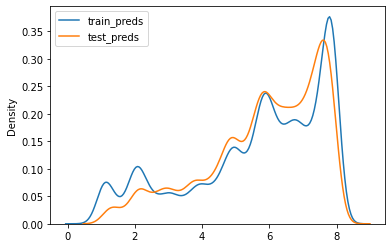

In [ ]:
# Stacked train data is used for training offset values, this reduces the chance of overfitting
train_preds = np.max(train_preds_stuck, axis= 1)
test_preds = np.max(test_preds_stuck, axis= 1)

sns.kdeplot(train_preds)
sns.kdeplot(test_preds)
plt.legend(['train_preds', 'test_preds'])
plt.show()

In [ ]:
from scipy.optimize import fmin_powell
print('Compute ensemble predictions')

print('Train offset values for label construction')
num_classes=np.unique(target).shape[0]

# Compute quantiles of test predictions
test_preds = pd.Series(test_preds).replace(np.nan, 0).astype('float64')

quant =[]
for q in range(1, 100):
    p = np.percentile(train_preds, q)
    quant.append(p)

#  Compute initial offset values based on the discrepancies between label distribution of train data and the distribution of test predictions    
# offsets = -1*np.array([quant[9] - 1.5 ,quant[20] - 2.5,quant[22] - 3.5,quant[24] - 4.5,0,quant[34] - 5.5,quant[53] - 6.5,quant[67] - 7.5]) 
# offsets= -np.ones(8)*0.5
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
# train offsets 
data = np.vstack((train_preds, train_preds, target))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(data, x, j)
    # train_offset = apply_offset(data, train_offset, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  


print('Apply offsets to test')
data = np.vstack((test_preds, test_preds))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

preds_subm = np.round(np.clip(data[1], 1, 8)).astype(int)


Compute ensemble predictions
Train offset values for label construction
Optimization terminated successfully.
         Current function value: -0.393689
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.403338
         Iterations: 2
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: -0.446584
         Iterations: 2
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: -0.466017
         Iterations: 3
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -0.523539
         Iterations: 2
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: -0.534648
         Iterations: 2
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: -0.563352
         Iterations

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/PrudentialData/test.csv')

pd.DataFrame(preds_subm, index = test['Id'], columns=['Response']).to_csv("/content/drive/MyDrive/PrudentialData/13XGBOOST/customoffset__maxtrainpreds13offset_xgboost.csv")

# XGBoost Offset Models

## Model_1

In [ ]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
from scipy.optimize import fmin_powell
from sklearn.metrics import cohen_kappa_score

def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y,weights='quadratic')
    
def get_params():
    
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 240
    params["subsample"] = 0.9
    params["colsample_bytree"] = 0.67
    params["silent"] = 1
    params["max_depth"] = 6
    plst = list(params.items())

    return plst
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# global variables
#columns_to_drop = ['Id', 'Response', 'Medical_History_10','Medical_History_24']
columns_to_drop = ['Id', 'Response']
xgb_num_rounds = 800
num_classes = 8
eta_list = [0.05] * 200 
eta_list = eta_list + [0.02] * 500
eta_list = eta_list + [0.01] * 100

print("Load the data using pandas")
train = pd.read_csv('/content/drive/MyDrive/PrudentialData/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PrudentialData/test.csv')


# combine train and test
all_data = train.append(test)

# Found at https://www.kaggle.com/marcellonegro/prudential-life-insurance-assessment/xgb-offset0501/run/137585/code
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

print('Eliminate missing values')    
# Use -1 for any others
all_data.fillna(-1, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()

# convert data to xgb data structure
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['Response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test['Response'].values)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

# train model
model = xgb.train(plst, xgtrain, xgb_num_rounds, learning_rates=eta_list) 

# get preds
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train score is:', eval_wrapper(train_preds, train['Response'])) 
test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
data = np.vstack((train_preds, train_preds, train['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(data, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# apply offsets to test
data = np.vstack((test_preds, test_preds, test['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

preds_out = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds})
preds_out = preds_out.set_index('Id')
preds_out.to_csv('xgb_offset_submission_2.csv')

Load the data using pandas
Eliminate missing values
[('objective', 'reg:linear'), ('eta', 0.05), ('min_child_weight', 240), ('subsample', 0.9), ('colsample_bytree', 0.67), ('silent', 1), ('max_depth', 6)]
Train score is: 0.6383863471928359
Optimization terminated successfully.
         Current function value: -0.691444
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.691444
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.691444
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.691969
         Iterations: 2
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: -0.691969
         Iterations: 1
         Function evaluations: 32
Optimization terminated successfully.
         Current function value:

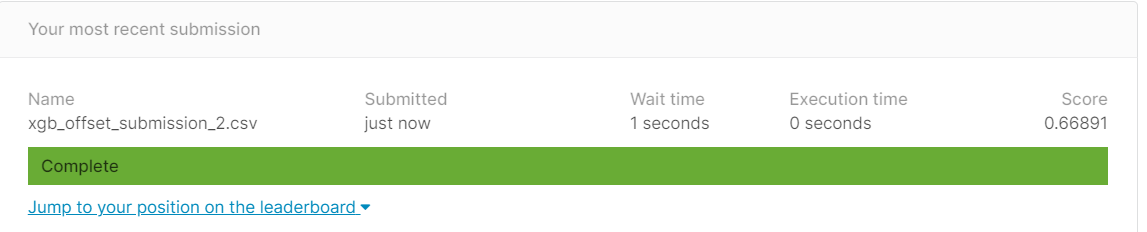

## Model_2

In [ ]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
from scipy.optimize import fmin_powell
from sklearn.metrics import cohen_kappa_score

def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y,weights='quadratic')
    
def get_params():
    
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 60
    params["subsample"] = 0.9
    params["colsample_bytree"] = 0.67
    params["silent"] = 1
    params["max_depth"] = 6
    plst = list(params.items())

    return plst
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# global variables
#columns_to_drop = ['Id', 'Response', 'Medical_History_10','Medical_History_24']
columns_to_drop = ['Id', 'Response']
xgb_num_rounds = 800
num_classes = 8
eta_list = [0.05] * 200 
eta_list = eta_list + [0.02] * 500
eta_list = eta_list + [0.01] * 100

print("Load the data using pandas")
train = pd.read_csv('/content/drive/MyDrive/PrudentialData/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PrudentialData/test.csv')


# combine train and test
all_data = train.append(test)

# Found at https://www.kaggle.com/marcellonegro/prudential-life-insurance-assessment/xgb-offset0501/run/137585/code
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

print('Eliminate missing values')    
# Use -1 for any others
all_data.fillna(-1, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()

# convert data to xgb data structure
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['Response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test['Response'].values)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

# train model
model = xgb.train(plst, xgtrain, xgb_num_rounds, learning_rates=eta_list) 

# get preds
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train score is:', eval_wrapper(train_preds, train['Response'])) 
test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
data = np.vstack((train_preds, train_preds, train['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(data, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# apply offsets to test
data = np.vstack((test_preds, test_preds, test['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

preds_out = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds})
preds_out = preds_out.set_index('Id')
preds_out.to_csv('xgb_offset_submission_3.csv')

Load the data using pandas
Eliminate missing values
[('objective', 'reg:linear'), ('eta', 0.05), ('min_child_weight', 60), ('subsample', 0.9), ('colsample_bytree', 0.67), ('silent', 1), ('max_depth', 6)]
Train score is: 0.6618241595919974
Optimization terminated successfully.
         Current function value: -0.715727
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.715727
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.715727
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.716021
         Iterations: 2
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.716074
         Iterations: 1
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 

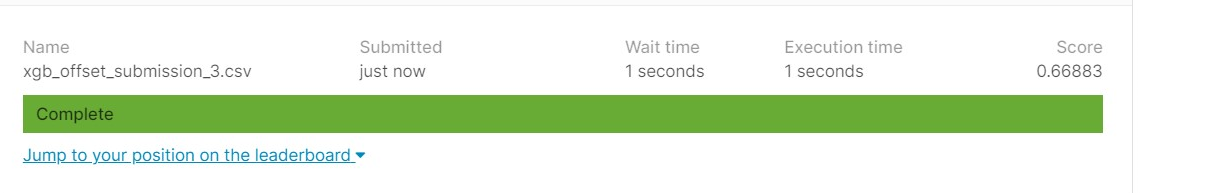

## Model_3

In [ ]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
from scipy.optimize import fmin_powell
from sklearn.metrics import cohen_kappa_score

def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y,weights='quadratic')
    
def get_params():
    
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 60
    params["subsample"] = 0.9
    params["colsample_bytree"] = 0.60
    params["silent"] = 1
    params["max_depth"] = 8
    plst = list(params.items())

    return plst
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# global variables
#columns_to_drop = ['Id', 'Response', 'Medical_History_10','Medical_History_24']
columns_to_drop = ['Id', 'Response']
xgb_num_rounds = 800
num_classes = 8
eta_list = [0.05] * 200 
eta_list = eta_list + [0.02] * 500
eta_list = eta_list + [0.01] * 100

print("Load the data using pandas")
train = pd.read_csv('/content/drive/MyDrive/PrudentialData/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PrudentialData/test.csv')


# combine train and test
all_data = train.append(test)

# Found at https://www.kaggle.com/marcellonegro/prudential-life-insurance-assessment/xgb-offset0501/run/137585/code
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

print('Eliminate missing values')    
# Use -1 for any others
all_data.fillna(-1, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()

# convert data to xgb data structure
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['Response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test['Response'].values)    

# get the parameters for xgboost
plst = get_params()
print(plst)      

# train model
model = xgb.train(plst, xgtrain, xgb_num_rounds, learning_rates=eta_list) 

# get preds
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train score is:', eval_wrapper(train_preds, train['Response'])) 
test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
data = np.vstack((train_preds, train_preds, train['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(data, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# apply offsets to test
data = np.vstack((test_preds, test_preds, test['Response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

preds_out = pd.DataFrame({"Id": test['Id'].values, "Response": final_test_preds})
preds_out = preds_out.set_index('Id')
preds_out.to_csv('xgb_offset_submission_4.csv')

Load the data using pandas
Eliminate missing values
[('objective', 'reg:linear'), ('eta', 0.05), ('min_child_weight', 60), ('subsample', 0.9), ('colsample_bytree', 0.6), ('silent', 1), ('max_depth', 8)]
Train score is: 0.7029430751160213
Optimization terminated successfully.
         Current function value: -0.754532
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.754532
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.754532
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.755011
         Iterations: 3
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -0.755022
         Iterations: 1
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: -

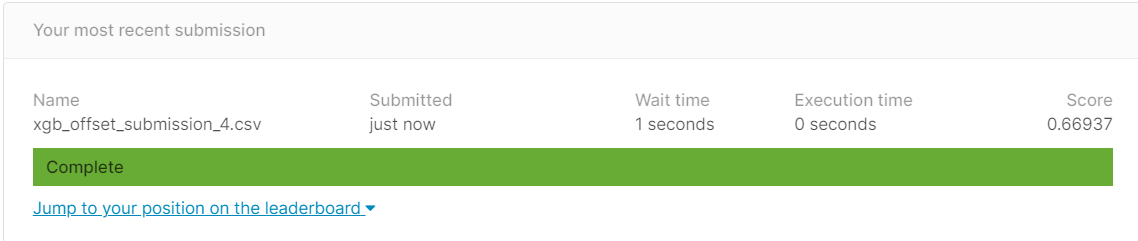

# Summarizing Results

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Index","Model Name", "Parameters", "Train Score", "CV Score"]
table.add_row([1,"KNN\n", 'n_neighbors : 5 ','0.81728','0.084512'])
table.add_row([2,"Naive Bayes\n", '[DEFAULT]','0.26686','0.26211'])
table.add_row([3,"Logistic Regression\n", "multi_class='ovr',penalty='elasticnet',solver= 'saga',l1_ratio=0.5'",'0.34349' , '0.329583'])
table.add_row([4,"Linear SVM using SGD\n", "loss: 'hinge'",'0.199822', '0.20303'])
table.add_row([5,"logistic Reg using SGD\n", "loss: 'log'",'0.11532','0.11797'])
table.add_row([6, "Decision Tree\n", "loss: 'log'",'0.398774','0.39027'])
table.add_row([7, "Random Forest\n", "max_depth=10, n_estimators=50,min_samples_leaf=2'",'0.49990','0.423037'])
table.add_row([8, "ExtraTrees Classifier\n", "[DEFAULT]'",'0.39877','0.20509'])
table.add_row([9, "XGBoost\n", "{max_depth: 3, learning_rate: 0.01, n_estimators: 1000, min_child_weight: 2}",'0.47874','0.45672'])
table.add_row([10, "LightGBM\n", "{learning_rate: 0.3, n_estimators: 200,max_depth: 2}",'0.52962','0.48450'])
table.add_row([11, "CatBoost Classifier\n", "{depth: 3, iterations: 50, learning_rate: 0.5}",'0.483191','0.470571'])
table.add_row([12, "AdaBoost Classifier\n", "{n_estimators: 50}",'0.39375','0.394268'])
table.add_row([13, "Voting Classifier\n with ADABoost, LGBM\n and CatBoost estimators\n", "-",'0.51336','0.480534'])
table.add_row([14, "Bumping Prob and Stacking \nXgboost models\n",'7 XGBClassifier with {learning_rate=0.1, max_depth=3,\n min_child_weight=2,n_estimators=500}\n  ','-','0.64174 {test}'])
table.add_row([15, "Custom Model with \n LGBM as Base model and as\n Stacking Classifier\n", "k= 200",'-','0.55910'])
table.add_row([16, "Custom Model with \n XGBoost as Base model as Random Forest as\n Stacking Classifier\n", "k= 100",'-','0.480521'])
table.add_row([17, "Custom Model with \n XGBoost as Base model as Logistic Reg as\n Stacking Classifier\n", "k= 50",'-','0.44064'])
table.add_row([18, "Custom Model with \n DecisionTree as Base model as Random Forest as\n Stacking Classifier\n", "k =500",'-','0.424895'])
table.add_row([19, "Custom Model with \n Logistic Reg as Base model and as\n Stacking Classifier\n", "k =75",'-','0.473943'])
table.add_row([20, "Custom Model with \n Logistic Reg as Base model and LGBM as\n Stacking Classifier\n", "k =150",'-','0.490028'])
table.add_row([21, "Custom Model with \n Logistic Reg as Base model and LGBM as\n Stacking Classifier\n", "k =150",'-','0.490028'])
table.add_row([22, "XGBoost with Predictions\n Offset\n", '{objective: "reg:linear", eta: 0.05, min_child_weight: 240, subsample: 0.9, \n colsample_bytree: 0.67, silent: 1, max_depth: 6, num_rounds: 800}','-','0.63838{CV}\n 0.66891{TEST}'])
table.add_row([23, "XGBoost with Predictions\n Offset\n", '{objective: "reg:linear", eta: 0.05, min_child_weight: 60, subsample: 0.9, \n colsample_bytree: 0.67, silent: 1, max_depth: 6, num_rounds: 800}','-','0.6618{CV}\n 0.66883{TEST}'])
table.add_row([24, "XGBoost with Predictions\n Offset\n", '{objective: "reg:linear", eta: 0.05, min_child_weight: 60, subsample: 0.9, \n colsample_bytree: 0.6, silent: 1, max_depth: 8, num_rounds: 800}','-','0.70294{CV}\n 0.66937{TEST}'])

print (table)

+-------+-------------------------------------------------+------------------------------------------------------------------------------+-------------+----------------+
| Index |                    Model Name                   |                                  Parameters                                  | Train Score |    CV Score    |
+-------+-------------------------------------------------+------------------------------------------------------------------------------+-------------+----------------+
|   1   |                       KNN                       |                               n_neighbors : 5                                |   0.81728   |    0.084512    |
|       |                                                 |                                                                              |             |                |
|   2   |                   Naive Bayes                   |                                  [DEFAULT]                                   |   0.26686  

# Conclusion

* The Best Results were obtained using XGBoost model with Offsetting done on    
test_predictions using train predictions.
* The final model gives us the Kappa Score of 0.66937 on Test data. 
  Since, this is a Kaggle Problem, the final leaderboard score is 0.679 and we tried achieving very close to the leaderboard.
  